In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

<b>Exploratory Data Analysis

In [2]:
#Import pbp data
seasons = range(2017, 2024)
pbp = nfl.import_pbp_data(seasons)

2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [3]:
#Filter pbp data to include only running plays
pbp_run = pbp.query("play_type == 'run' & rusher_id.notnull()").reset_index()

In [5]:
#Replace missing rushing yard values with 0
pbp_run.loc[pbp_run['rushing_yards'].isnull(), 'rushing_yards'] = 0

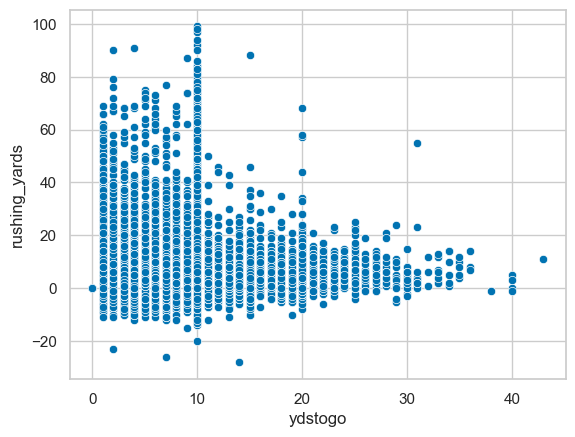

In [6]:
#Plot the raw data
sns.set_theme(style='whitegrid', palette='colorblind')
sns.scatterplot(data=pbp_run, x='ydstogo', y='rushing_yards');
plt.show();

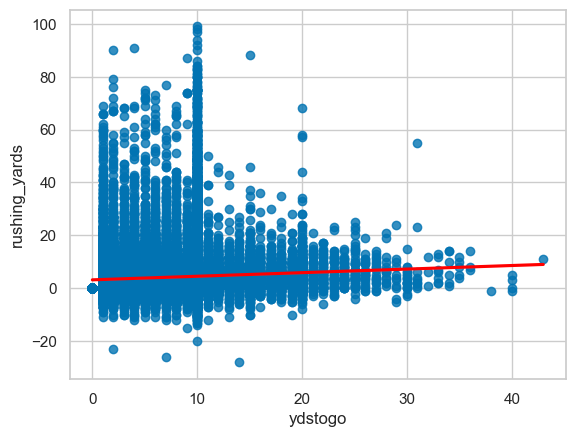

In [11]:
#Plot the data again, but this time with a regression line
sns.regplot(data=pbp_run, x='ydstogo', y='rushing_yards', line_kws={'color': 'red'});
plt.show();

In [14]:
#Calculate yards-per-carry (YPC) for each ydstogo bin
pbp_run_avg = pbp_run.groupby('ydstogo').aggregate({'rushing_yards': ['mean']})

pbp_run_avg.columns = list(map('_'.join, pbp_run_avg.columns))

pbp_run_avg.reset_index(inplace=True)

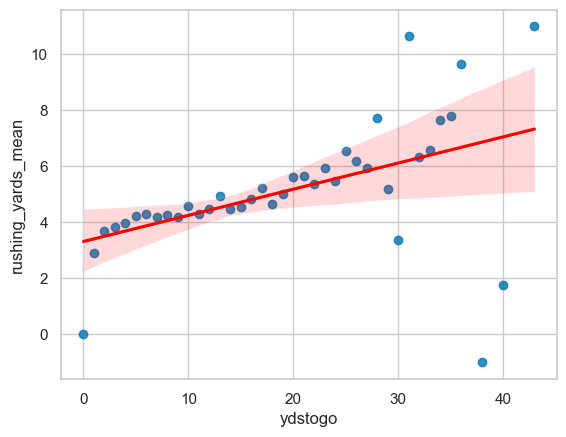

In [16]:
#Re-plot a regression plot, this time using YPC per each bin of ydstogo
sns.regplot(data=pbp_run_avg, x='ydstogo', y='rushing_yards_mean', line_kws={'color': 'red'});
plt.show();

<b>Simple Linear Regression

In [17]:
#Build the linear regression model
yds_to_go = smf.ols(formula='rushing_yards ~ 1 + ydstogo', data=pbp_run)

In [18]:
#Fit the model and view its summary
print(yds_to_go.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     660.4
Date:                Sun, 16 Jun 2024   Prob (F-statistic):          3.98e-145
Time:                        13:49:41   Log-Likelihood:            -3.0334e+05
No. Observations:               93377   AIC:                         6.067e+05
Df Residuals:                   93375   BIC:                         6.067e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1975      0.047     68.761      0.0

In [19]:
#Create an RYOE column in the pbp_run dataframe using the model's residuals
pbp_run['ryoe'] = yds_to_go.fit().resid

<b>RYOE Analysis

In [20]:
#Group RYOE data by season, player id and player name
ryoe_df = (pbp_run.groupby(['season', 'rusher_id', 'rusher'])
            .agg({'ryoe': ['count', 'sum', 'mean'], 'rushing_yards': 'mean'}))

ryoe_df.columns = list(map('_'.join, ryoe_df.columns))

ryoe_df.reset_index(inplace=True)

In [22]:
#Rename the columns and filter on players with > 50 rushing attempts
ryoe_df = ryoe_df.rename(columns={
    'ryoe_count': 'n',
    'ryoe_sum': 'ryoe_total',
    'ryoe_mean': 'ryoe_per',
    'rushing_yards_mean': 'ypc'
    }
).query('n > 50')

In [23]:
ryoe_df.sort_values(by='ryoe_total', ascending=False).head(10)

,season,rusher_id,rusher,n,ryoe_total,ryoe_per,ypc
1658,2021,00-0036223,J.Taylor,332,418.509172,1.260570,5.454819
1109,2020,00-0032764,D.Henry,397,363.266561,0.915029,5.206549
927,2019,00-0034796,L.Jackson,135,354.104563,2.622997,6.800000
2174,2023,00-0033280,C.McCaffrey,331,332.563397,1.004723,5.217523
2453,2023,00-0039040,D.Achane,109,331.893437,3.044894,7.422018
813,2019,00-0032764,D.Henry,387,324.392511,0.838224,5.131783
1143,2020,00-0033293,A.Jones,222,288.848574,1.301120,5.540541
772,2019,00-0031687,R.Mostert,190,281.755342,1.482923,5.831579
1904,2022,00-0034796,L.Jackson,73,276.271029,3.784535,7.821918
1569,2021,00-0034791,N.Chubb,228,276.060453,1.210791,5.521930


<b>Predictability of RYOE

In [24]:
#Create a list of columns to keep
cols_keep = ['season', 'rusher_id', 'rusher', 'ryoe_per', 'ypc']

In [25]:
#Create current dataframe
ryoe_df_now = ryoe_df[cols_keep].copy()

In [26]:
#Create last year's dataframe
ryoe_df_last = ryoe_df[cols_keep].copy()

In [27]:
#Rename columns
ryoe_df_last.rename(columns={'ryoe_per': 'ryoe_per_last', 'ypc': 'ypc_last'}, inplace=True)

In [28]:
#Add 1 to season
ryoe_df_last['season'] += 1

In [29]:
#Merge the current and last year dataframe together
ryoe_lag = ryoe_df_now.merge(ryoe_df_last, how='inner', on=['rusher_id', 'rusher', 'season'])

In [30]:
#Examine the correlation for YPC
ryoe_lag[['ypc_last', 'ypc']].corr()

,ypc_last,ypc
ypc_last,1.000000,0.359104
ypc,0.359104,1.000000


In [32]:
#Repeaat with RYOE
ryoe_lag[['ryoe_per_last', 'ryoe_per']].corr()

,ryoe_per_last,ryoe_per
ryoe_per_last,1.000000,0.378862
ryoe_per,0.378862,1.000000


For player's with greater than 50 rushing attempts, RYOE is slightly more stable year-over-year than regular YPC.